In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('train_Loan_Prediction.csv')

In [3]:
train = df.drop(['Loan_ID', 'Gender', 'Married', 'Self_Employed'], axis=1)

In [4]:
train.dtypes

Dependents            object
Education             object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [5]:
# fill with mode the columns
# mode_col = ['Dependents', 'Loan_Amount_Term', 'Credit_History']
train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)

In [6]:
train['LoanAmount'] = train['LoanAmount'].fillna(train['LoanAmount'].mean())
train['LoanAmount'].head()

0    146.412162
1    128.000000
2     66.000000
3    120.000000
4    141.000000
Name: LoanAmount, dtype: float64

In [7]:
train.shape

(614, 9)

In [8]:
train.Loan_Amount_Term.unique()

array([ 360.,  120.,  240.,  180.,   60.,  300.,  480.,   36.,   84.,   12.])

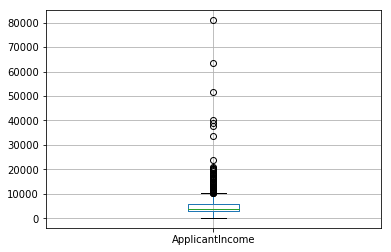

In [9]:
train.boxplot(column='ApplicantIncome')

In [10]:
train['Dependents'] = train['Dependents'].replace('3+', 3)
train['Dependents'] = train['Dependents'].astype(int)

In [11]:
# take care of quantile: delete obs for Loan_Amount_Term

In [12]:
Q1 = train.Loan_Amount_Term.quantile(0.25)
Q3 = train.Loan_Amount_Term.quantile(0.75)
IQR = Q3 - Q1
train = train.query('(@Q1 - 1.5*@IQR) <= Loan_Amount_Term <= (@Q3 + 1.5*@IQR)')
train.shape

(526, 9)

In [13]:
# transforming variables: Property_Area for dummy; Education and Loan_Status for simple label

In [14]:
dummy = pd.get_dummies(train.Property_Area)
dummy.head()

,Rural,Semiurban,Urban
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [15]:
train = pd.concat([train, dummy], axis=1)

In [16]:
train = train.drop('Property_Area', axis=1)
train.head(10)

,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Rural,Semiurban,Urban
0,0,Graduate,5849,0.0,146.412162,360.0,1.0,Y,0,0,1
1,1,Graduate,4583,1508.0,128.000000,360.0,1.0,N,1,0,0
2,0,Graduate,3000,0.0,66.000000,360.0,1.0,Y,0,0,1
3,0,Not Graduate,2583,2358.0,120.000000,360.0,1.0,Y,0,0,1
4,0,Graduate,6000,0.0,141.000000,360.0,1.0,Y,0,0,1
5,2,Graduate,5417,4196.0,267.000000,360.0,1.0,Y,0,0,1
6,0,Not Graduate,2333,1516.0,95.000000,360.0,1.0,Y,0,0,1
7,3,Graduate,3036,2504.0,158.000000,360.0,0.0,N,0,1,0
8,2,Graduate,4006,1526.0,168.000000,360.0,1.0,Y,0,0,1
9,1,Graduate,12841,10968.0,349.000000,360.0,1.0,N,0,1,0


In [17]:
le = LabelEncoder()
train['Education'] = le.fit_transform(train['Education'])

In [18]:
train['Loan_Status'] = le.fit_transform(train['Loan_Status'])
train.head()

,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Rural,Semiurban,Urban
0,0,0,5849,0.0,146.412162,360.0,1.0,1,0,0,1
1,1,0,4583,1508.0,128.000000,360.0,1.0,0,1,0,0
2,0,0,3000,0.0,66.000000,360.0,1.0,1,0,0,1
3,0,1,2583,2358.0,120.000000,360.0,1.0,1,0,0,1
4,0,0,6000,0.0,141.000000,360.0,1.0,1,0,0,1


In [19]:
X = train.drop('Loan_Status', axis=1)
y = train['Loan_Status']

In [20]:
y.value_counts()

1    367
0    159
Name: Loan_Status, dtype: int64

In [21]:
# define logistic regression
log_reg = LogisticRegression()

In [22]:
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
# print coefficient
log_reg.coef_

array([[  1.21143199e-01,  -2.68893307e-01,  -2.74895157e-05,
         -3.17516542e-05,  -2.11497149e-03,  -4.48974722e-03,
          3.42733682e+00,  -3.72826470e-01,   5.53796061e-01,
         -1.80982063e-01]])

In [24]:
# print intercept
log_reg.intercept_

array([ -1.24715201e-05])

In [25]:
# get predictions
pred_lr = log_reg.predict(X)

In [26]:
accuracy_score(y, pred_lr)

0.81749049429657794

In [27]:
f1_score(y, pred_lr)

0.88264058679706603

In [28]:
pred_prob = log_reg.predict_proba(X)
log_loss(y, pred_prob[:, 0])

1.4882545005896792

In [29]:
# create Naive Bayes
bnb = BernoulliNB()
bnb.fit(X, y)
accuracy_score(y, bnb.predict(X))

0.81558935361216733

In [30]:
gnb = GaussianNB()
gnb.fit(X, y)
accuracy_score(y, gnb.predict(X))

0.80608365019011408

In [31]:
# the scores are almost the same: Gaussian < Bernoulli < Logistic Regression 

In [32]:
###'ENSEMBLE MODELS'###
### 1. Averaging ###

In [33]:
roc_auc_score(y, pred_prob[:, 1]) # log reg

0.78664336023854808

In [34]:
roc_auc_score(y, gnb.predict_proba(X)[:, 1]) # gaussian naive bayes

0.78225626788682678

In [35]:
avg_pred = (gnb.predict_proba(X)[:, 1] + pred_prob[:, 1]) / 2

In [36]:
roc_auc_score(y, avg_pred)

0.78511816016314495

In [37]:
### 2. Weighted Averaging ###

In [38]:
wavg_pred = gnb.predict_proba(X)[:, 1]*0.1 + pred_prob[:, 1]*0.9

In [39]:
roc_auc_score(y, wavg_pred)

0.78575223210460465

In [40]:
### 3. Voting ###

In [41]:
vt = VotingClassifier([('gnb', gnb), ('log_reg', log_reg)], voting='soft')

In [42]:
vt.fit(X, y)

VotingClassifier(estimators=[('gnb', GaussianNB(priors=None)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))],
         n_jobs=1, voting='soft', weights=None)

In [43]:
roc_auc_score(y, vt.predict_proba(X)[:, 1])

0.78511816016314495

In [44]:
### 4. Weighted Voting ###

In [45]:
vt = VotingClassifier([('gnb', gnb), ('log_reg', log_reg)], weights=[0.1, 0.9])

In [46]:
vt.fit(X, y)

VotingClassifier(estimators=[('gnb', GaussianNB(priors=None)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))],
         n_jobs=1, voting='hard', weights=[0.1, 0.9])

In [47]:
roc_auc_score(y, vt.predict(X))

0.70880674515449082

In [48]:
print ('naive bayes score:', accuracy_score(y, gnb.predict(X)))
print ('logReg score:', accuracy_score(y, log_reg.predict(X)))
print ('ensemble score:', accuracy_score(y, vt.predict(X)))

naive bayes score: 0.80608365019
logReg score: 0.817490494297
ensemble score: 0.817490494297


In [49]:
### 5. Bagging (Random Forest) ###

In [50]:
rmf = RandomForestClassifier(n_estimators=100, max_depth=10)

In [51]:
rmf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [52]:
roc_auc_score(y, rmf.predict(X))

0.9308176100628931